# **Exploratory Data Analysis (EDA) of the Lynx-ID dataset**

In [34]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

ERROR! Session/line number was not unique in database. History logging moved to new session 1312
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lynx_id.data.dataset import LynxDataset
from lynx_id.data.collate import collate_single

from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader

## Load dataset and retrieve csv

In [36]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")

In [37]:
full_dataset = LynxDataset(
    dataset_csv=DATASET / "lynx_dataset_full_v2.csv",
    countries=['all'],
    mode='single',
    device='auto',
    verbose=False,
    probabilities=[1, 0, 0]  # only classic images
)

/gpfsdswork/projects/rech/ads/uxp55sd/DP-SCR_Identify-and-estimate-density-lynx-population/lynx_id/data/dataset.py:43: DtypeWarning: Columns (2,3,4,5,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataframe = pd.read_csv(self.dataset_csv)


In [38]:
full_df = full_dataset.dataframe

## General informations

In [39]:
print(f"In the dataset, we have {len(full_df)} images of lynx.")

In the dataset, we have 35744 images of lynx.


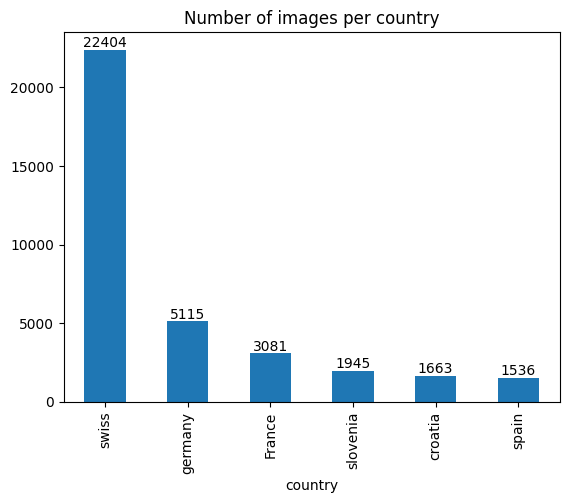

In [40]:
plt.title('Number of images per country')
ax = full_df['country'].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

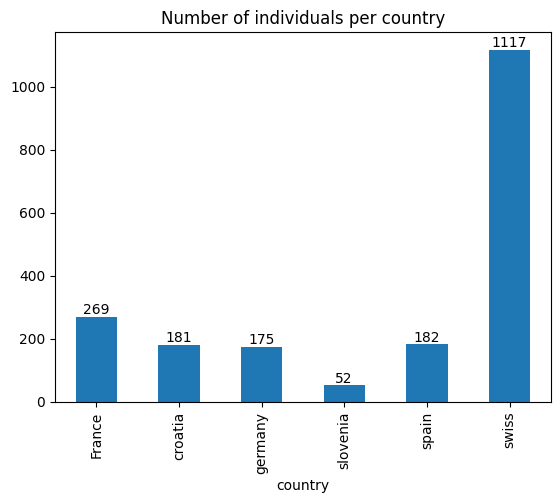

In [41]:
plt.title('Number of individuals per country')
ax = full_df.groupby('country')['lynx_id'].nunique().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

Are the same `lynx_id` used for several countries?

In [42]:
count_lynx_id = len(full_df['lynx_id'].value_counts())
count_lynx_id_by_country = full_df.groupby('country')['lynx_id'].nunique().sum()

print(f"{abs(count_lynx_id_by_country - count_lynx_id)} identical lynx_id are used for different countries.")

205 identical lynx_id are used for different countries.


In [43]:
multiple_countries = full_df.groupby('lynx_id')['country'].unique()
print(multiple_countries[multiple_countries.apply(len) > 1])

lynx_id
10      [germany, swiss]
100      [France, swiss]
1015     [France, swiss]
1017     [France, swiss]
1018     [France, swiss]
              ...       
mata     [France, swiss]
naia      [swiss, spain]
odin    [croatia, swiss]
toni    [croatia, swiss]
zita    [croatia, swiss]
Name: country, Length: 202, dtype: object


In [44]:
full_df.dtypes

filepath            object
lynx_id             object
source              object
pattern             object
date                object
location            object
image_number         int64
conf               float64
x                  float64
y                  float64
width              float64
height             float64
country             object
filepath_no_bg      object
score_sam          float64
number_animals     float64
number_children    float64
sex                 object
side                object
latitude           float64
longitude          float64
dtype: object

In [45]:
full_df.describe()

,image_number,conf,x,y,width,height,score_sam,number_animals,number_children,latitude,longitude
count,35744.000000,35744.000000,35744.000000,35744.000000,35744.000000,35744.000000,35744.000000,1663.0,1663.000000,3608.000000,3608.000000
mean,42.295882,0.934407,777.599652,682.218441,874.993764,633.413577,0.966596,1.0,0.002405,31.672117,28.553680
std,63.052368,0.065171,732.892547,419.777858,601.825975,415.590839,0.031236,0.0,0.048999,15.212516,15.036556
min,1.000000,0.500000,0.000000,0.000000,16.998400,15.000000,0.252769,1.0,0.000000,14.408113,13.957060
25%,6.000000,0.928000,239.820800,406.886400,467.785600,361.920000,0.960373,1.0,0.000000,15.206706,14.730940
50%,18.000000,0.957000,642.816000,641.894400,744.940800,534.988800,0.973576,1.0,0.000000,45.523400,15.090534
75%,50.000000,0.970000,1090.970400,875.752400,1118.822400,781.977600,0.981911,1.0,0.000000,45.726612,44.755790
max,472.000000,0.993000,6396.633600,3391.549600,8457.119000,5366.790000,1.032513,1.0,1.000000,46.437879,45.693027


## NaN

### Columns without NaN

In [46]:
full_df.dropna(axis=1, how='all').columns

Index(['filepath', 'lynx_id', 'source', 'pattern', 'date', 'location',
       'image_number', 'conf', 'x', 'y', 'width', 'height', 'country',
       'filepath_no_bg', 'score_sam', 'number_animals', 'number_children',
       'sex', 'side', 'latitude', 'longitude'],
      dtype='object')

### Percentage of NaN values per column

In [47]:
full_df.groupby('country').apply(lambda x: x.drop(columns=["filepath"]).apply(lambda col: col.isna().mean() * 100))

/tmp/ipykernel_1512134/3221472174.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_df.groupby('country').apply(lambda x: x.drop(columns=["filepath"]).apply(lambda col: col.isna().mean() * 100))


,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height,country,filepath_no_bg,score_sam,number_animals,number_children,sex,side,latitude,longitude
country,,,,,,,,,,,,,,,,,,,,
France,0.0,0.0,4.089581,0.908796,6.653684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.000000,100.0,100.0,100.0
croatia,0.0,0.0,100.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
germany,0.0,100.0,100.000000,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.000000,100.0,100.0,100.0
slovenia,0.0,100.0,100.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,2.879177,100.0,0.0,0.0
spain,0.0,100.0,100.000000,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.000000,100.0,100.0,100.0
swiss,0.0,100.0,100.000000,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.000000,100.0,100.0,100.0


## Sex

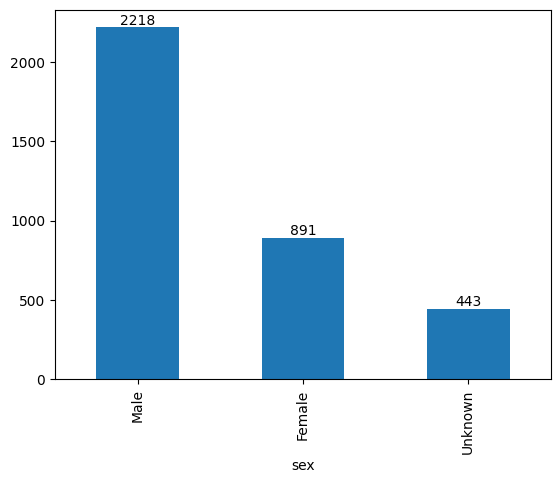

In [48]:
ax = full_df['sex'].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

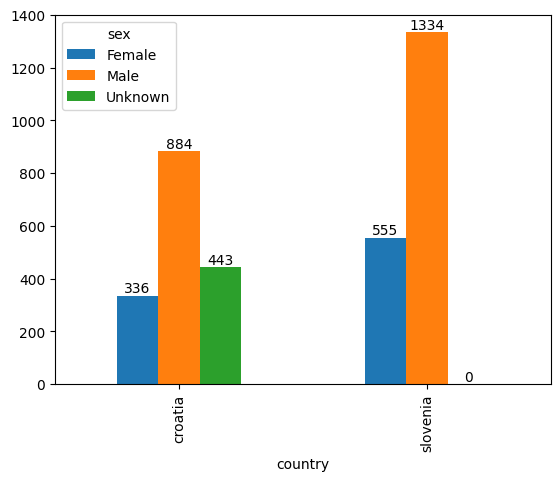

In [49]:
ax = full_df.groupby('country')['sex'].value_counts().unstack().plot(kind='bar')
for container in ax.containers:
    ax.bar_label(container)

## Location

In [50]:
location_value_counts = full_df['location'].value_counts()

print(f"There are {len(location_value_counts)} unique locations.")

There are 402 unique locations.


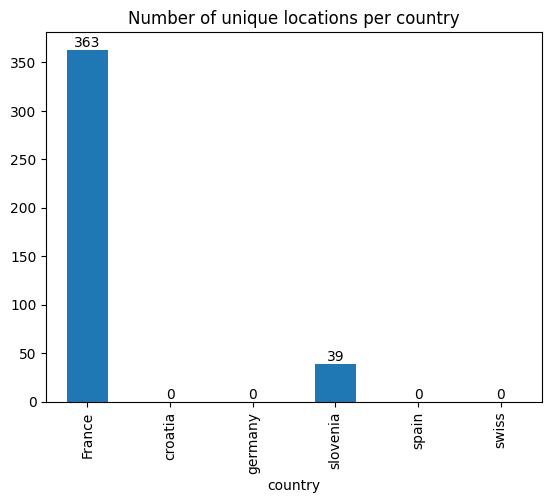

In [51]:
plt.title('Number of unique locations per country')
ax = full_df.groupby('country')['location'].nunique().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

In [52]:
full_df[full_df['country'] == 'France']['location'].value_counts()

location
Syam                        102
Les-Planches-En-Montagne     87
Contrevoz                    75
Les-Combes                   74
Orchamps-Vennes              66
                           ... 
Corlier-Pre-Du-Mollard        1
Chenecey-Buillon              1
Poizat-Riffard                1
Hauts-de-Biennes              1
Seillonnaz                    1
Name: count, Length: 363, dtype: int64

In [53]:
full_df[full_df['country'] == 'Slovenia']['location'].value_counts()

Series([], Name: count, dtype: int64)

### Number of images per pattern

In [54]:
full_df["pattern"].value_counts()

pattern
OCELLES    2227
SPOTS       728
Name: count, dtype: int64

## Number of images per individuals

In [55]:
nb_images_per_individuals = full_df["lynx_id"].value_counts()

print(f"{len(nb_images_per_individuals)} unique individuals")

1771 unique individuals


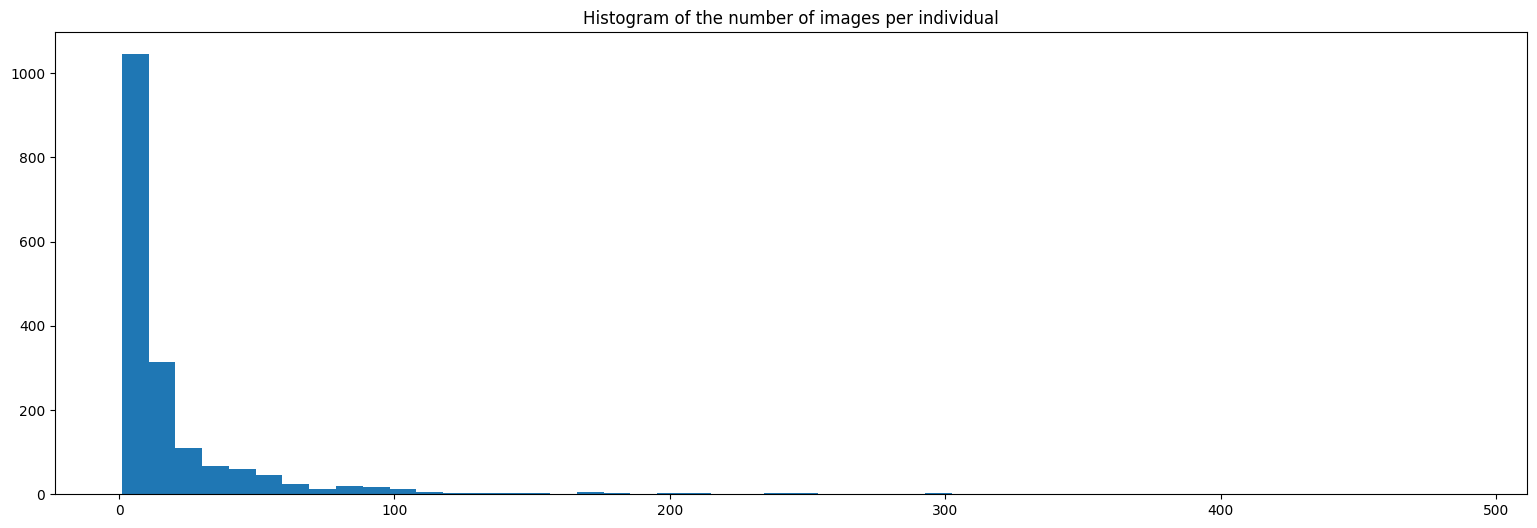

In [56]:
plt.figure(figsize=(19, 6))
plt.hist(nb_images_per_individuals, bins=50)
plt.title("Histogram of the number of images per individual")
plt.show()

In [57]:
print(f"On average, there are {np.mean(nb_images_per_individuals)} images per individual")

On average, there are 20.182947487295312 images per individual


In [58]:
print(f"{len(nb_images_per_individuals[nb_images_per_individuals < 3])} individuals have less than 3 images")

298 individuals have less than 3 images


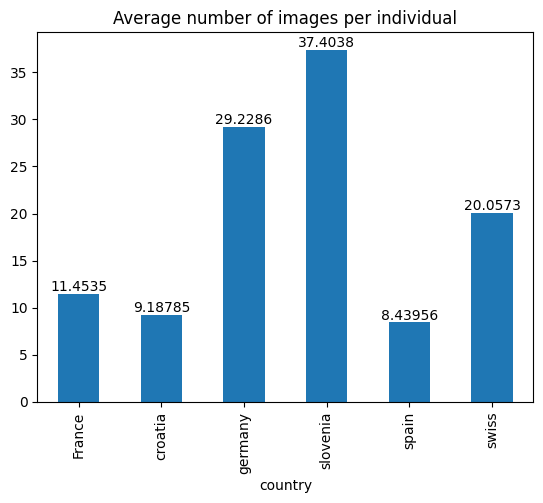

In [59]:
plt.title("Average number of images per individual")
ax = full_df.groupby('country')['lynx_id'].value_counts().groupby('country').mean().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

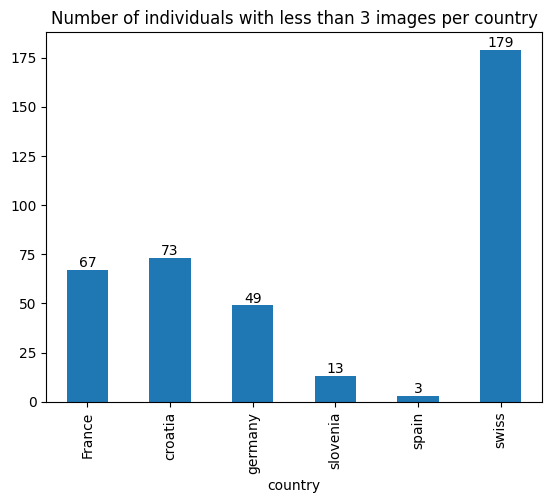

In [60]:
plt.title("Number of individuals with less than 3 images per country")
ax = (full_df.groupby('country')['lynx_id'].value_counts() < 3).groupby('country').sum().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

## Date

In [61]:
countries_with_all_dates_nan = full_df.groupby('country')['date'].apply(lambda x: x.isna().all())
countries_with_all_dates_nan

country
France      False
croatia     False
germany      True
slovenia    False
spain        True
swiss        True
Name: date, dtype: bool

In [62]:
full_df["date"] = pd.to_datetime(full_df["date"], format='ISO8601')

In [63]:
oldest_date = full_df["date"].min()
latest_date = full_df["date"].max()

print(f"Oldest date: {oldest_date}")
print(f"Latest date: {latest_date}")

Oldest date: 2006-01-01 00:00:00
Latest date: 2023-11-06 07:19:00


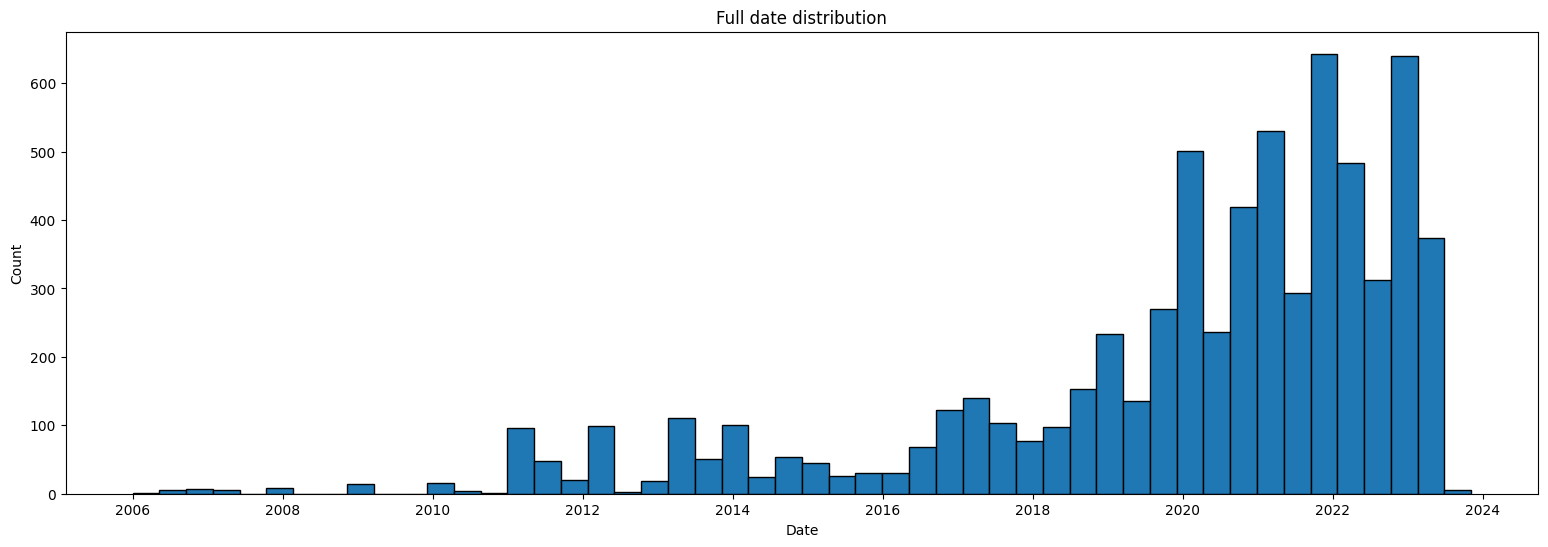

In [64]:
try:
    plt.figure(figsize=(19, 6))
    plt.hist(full_df["date"], bins=50, edgecolor="black")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.title("Full date distribution")
except:
    print("No date")

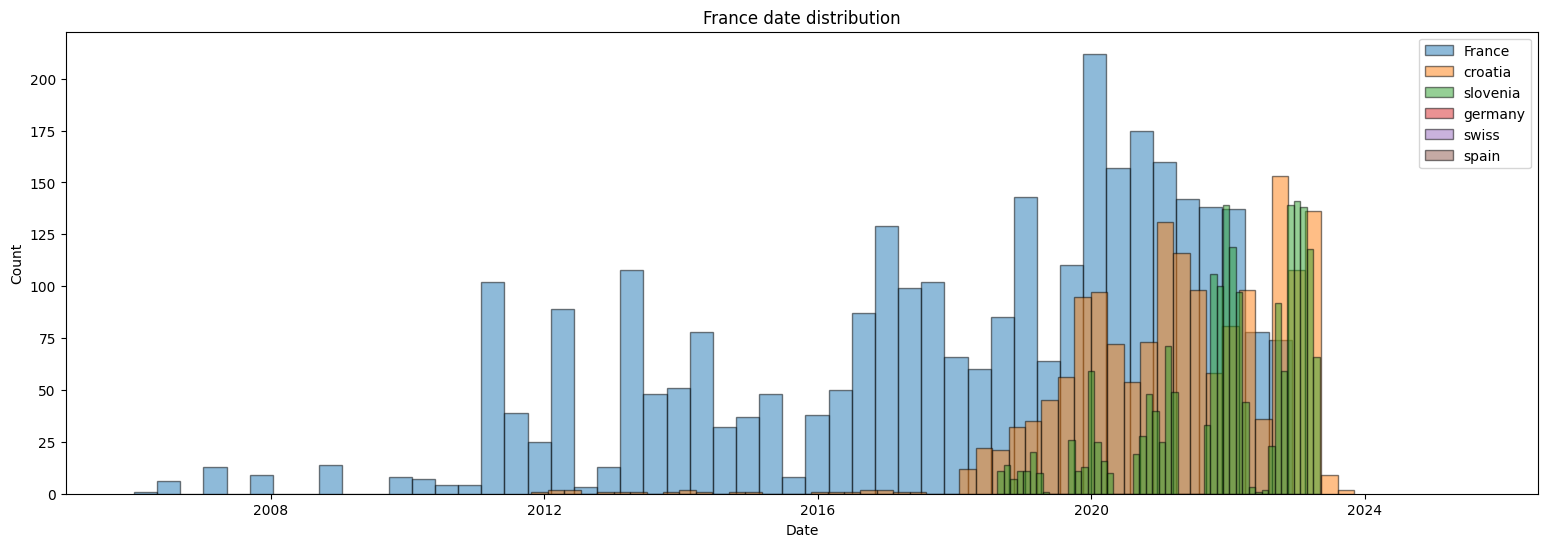

In [65]:
plt.figure(figsize=(19, 6))

for country in full_df['country'].unique():
    country_date = full_df[full_df['country'] == country]["date"]
    country_date = country_date.dropna()
    plt.hist(country_date, bins=50, alpha=0.5, edgecolor="black", label=country)

plt.xlabel("Date")
plt.ylabel("Count")
plt.title("France date distribution")
plt.legend()

plt.xlim(np.datetime64('2005-01-01'))

plt.show()

## Image
### Image dimensions

In [31]:
batch_size = 32

dataloader = DataLoader(
    dataset=full_dataset,
    batch_size=batch_size,
    collate_fn=collate_single,
    shuffle=False,
    num_workers=8,
    prefetch_factor=2,
)

In [32]:
heights = []
widths = []
    
for i, batch in enumerate(tqdm(dataloader)):
    for img in batch[0]['image']:
        heights.append(img.shape[0])
        widths.append(img.shape[1])

100%|██████████| 370/370 [05:20<00:00,  1.15it/s]


In [33]:
full_df['img_height'] = heights
full_df['img_width'] = widths

In [34]:
average_width = sum(widths)/len(widths)
average_height = sum(heights)/len(heights)

print('Average width: {} and height: {}'.format(average_width, average_height))

Average width: 2682.169146238377 and height: 1876.1972950126797


### Distribution of image dimensions

Text(0.5, 1.0, 'Plot of image dimensions per country')

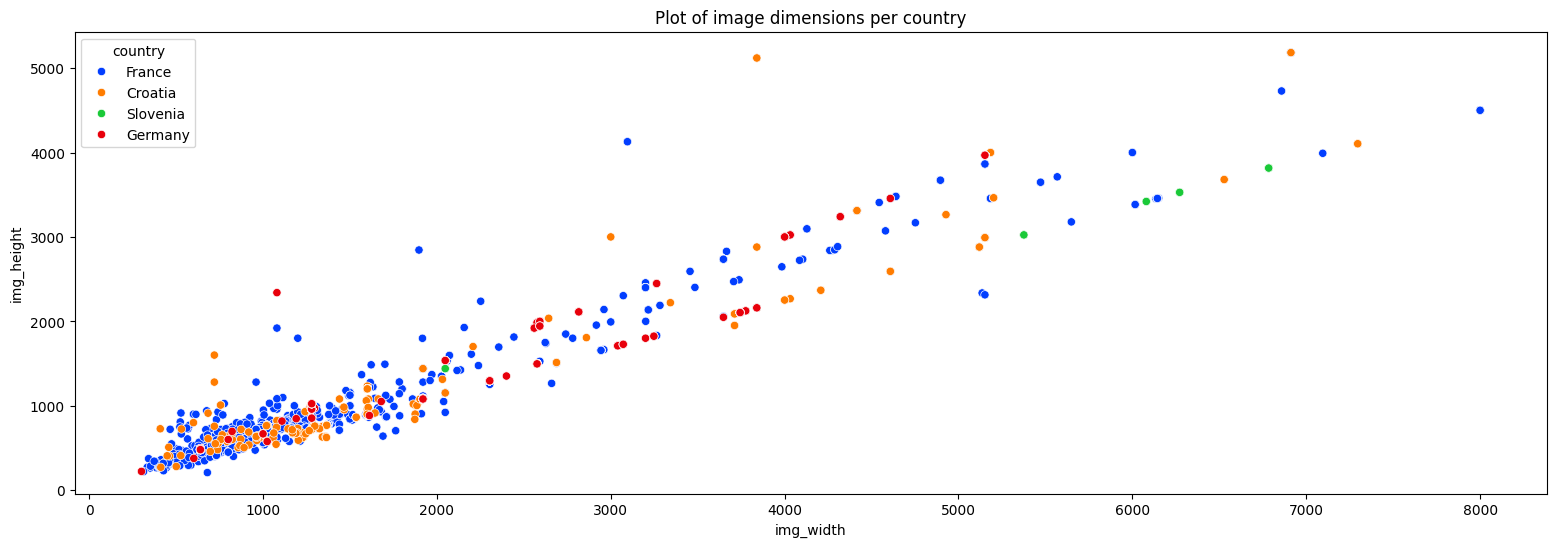

In [35]:
plt.figure(figsize=(19, 6))
sns.scatterplot(data=full_df, x='img_width', y='img_height', hue='country', alpha=1, palette='bright')
plt.title('Plot of image dimensions per country')

In [36]:
print(f"Lowest height : {min(heights)}")
print(f"Highest height : {max(heights)}")

print(f"Lowest width : {min(widths)}")
print(f"Highest widths : {max(widths)}")

Lowest height : 208
Highest height : 5184
Lowest width : 301
Highest widths : 8000


### Smallest images per country

In [37]:
full_df['total_dimension'] = full_df['img_width'] + full_df['img_height']

In [38]:
full_df.groupby('country').apply(lambda x: x.loc[x['total_dimension'].idxmin(), ['img_width', 'img_height']])

,img_width,img_height
country,,
Croatia,412,271
France,313,220
Germany,301,222
Slovenia,1920,1080


### Largest images by country

In [39]:
full_df.groupby('country').apply(lambda x: x.loc[x['total_dimension'].idxmax(), ['img_width', 'img_height']])

,img_width,img_height
country,,
Croatia,6912,5184
France,8000,4500
Germany,5152,3968
Slovenia,6784,3816


### Width and height distribution

Text(0.5, 1.0, 'Image height')

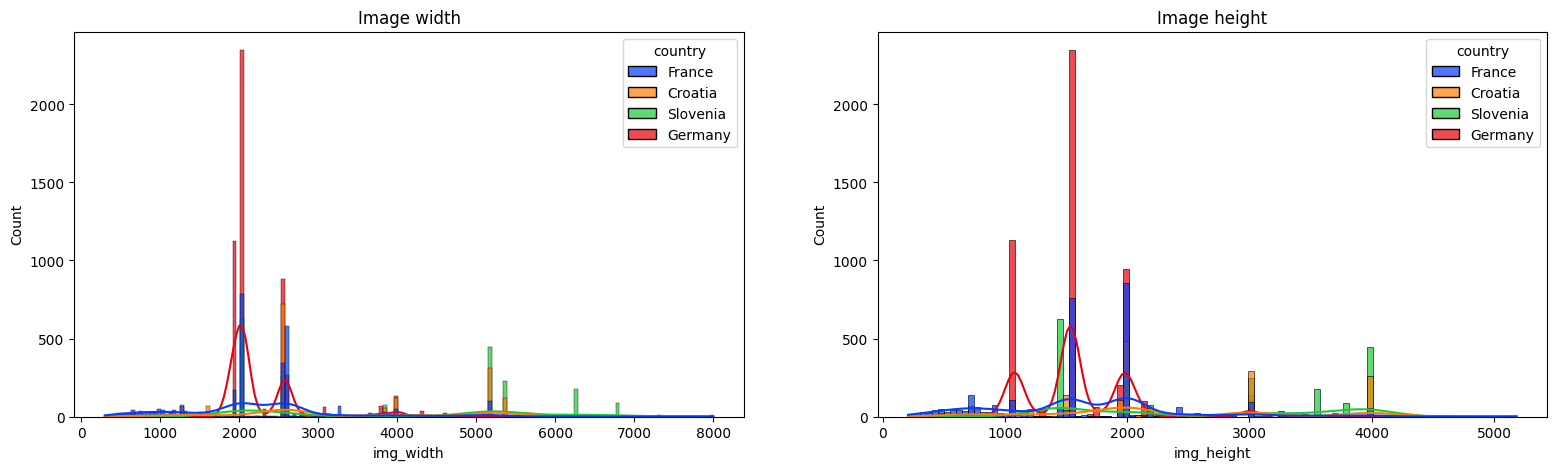

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(19, 5))

sns.histplot(data=full_df, kde=True, x='img_width', hue='country', alpha=0.7, palette='bright', ax=axes[0])
axes[0].set_title("Image width")

sns.histplot(data=full_df, kde=True, x='img_height', hue='country', alpha=0.7, palette='bright', ax=axes[1])
axes[1].set_title("Image height")

Text(0.5, 1.0, 'Image height')

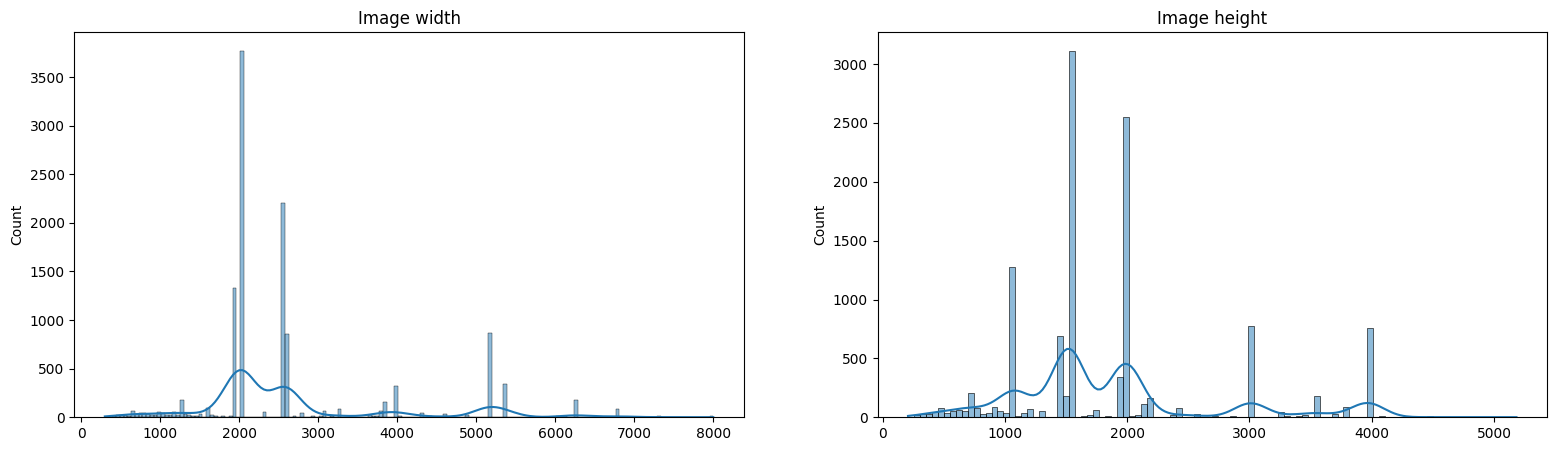

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(19, 5))

sns.histplot(widths, kde=True, ax=axes[0])
axes[0].set_title("Image width")
sns.histplot(heights, kde=True, ax=axes[1])
axes[1].set_title("Image height")

### Ratio distribution

In [42]:
full_df['ratio'] = full_df['img_width'] / full_df['img_height']

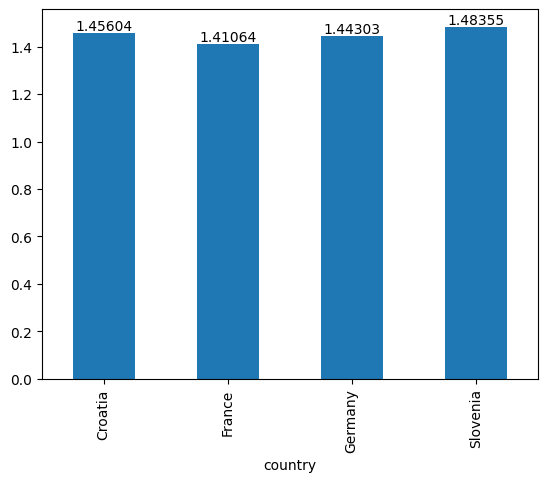

In [43]:
ax = full_df.groupby('country')['ratio'].mean().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

In [44]:
ratios = []
for height, width in zip(heights, widths):
    ratios.append(width/height)
        
print(f"Mean ratio: {np.mean(ratios)}")

Mean ratio: 1.443120111639496


Text(0.5, 1.0, 'Ratio distribution')

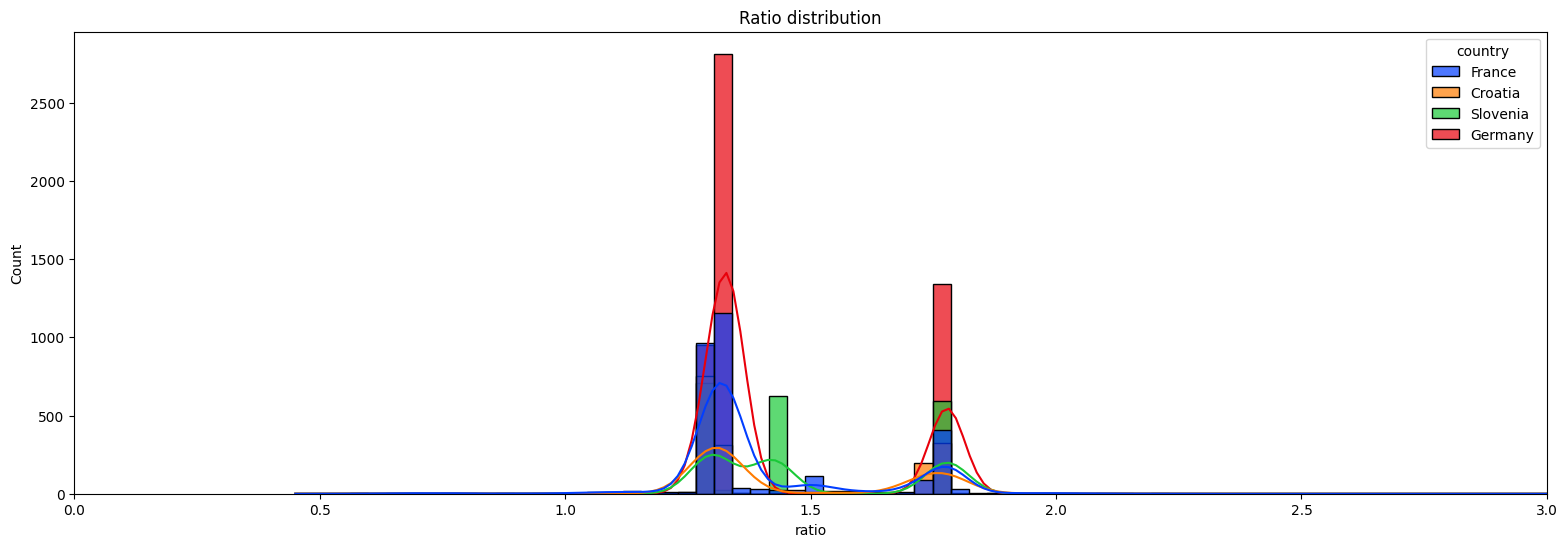

In [45]:
plt.figure(figsize=(19, 6))
sns.histplot(data=full_df, kde=True, x='ratio', hue='country', alpha=0.7, palette='bright')
plt.xlim(0,3)
plt.title("Ratio distribution")

### Image color (coloured or black and white image)

In [6]:
def is_black_and_white(img, threshold=10, show_score=False):
    diff_rg = np.abs(img[:, :, 0] - img[:, :, 1])
    diff_gb = np.abs(img[:, :, 1] - img[:, :, 2])
    diff_rb = np.abs(img[:, :, 0] - img[:, :, 2])
    
    avg_diff = (diff_rg + diff_gb + diff_rb) / 3
    
    if show_score:
        print(np.mean(avg_diff))
    
    is_bw = np.mean(avg_diff) < threshold
    
    return is_bw

In [8]:
batch_size = 64

dataloader = DataLoader(
    dataset=full_dataset,
    batch_size=batch_size,
    collate_fn=collate_single,
    shuffle=False,
    num_workers=4,
    prefetch_factor=2,
)

In [9]:
is_coloured = []

for i, batch in enumerate(tqdm(dataloader)):
    for img in batch[0]['image']:
        try:
            if is_black_and_white(img):
                is_coloured.append(False)
            else:
                is_coloured.append(True)
        except:
            print(f"Problem with image {i}")
            continue

100%|██████████| 185/185 [14:21<00:00,  4.65s/it]


In [10]:
full_df['is_coloured'] = is_coloured

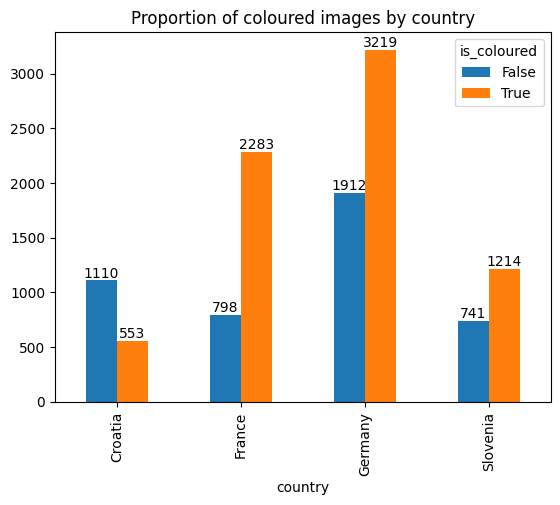

In [11]:
ax = full_df.groupby(['country', 'is_coloured']).size().unstack().plot(kind='bar', title='Proportion of coloured images by country')
for container in ax.containers:
    ax.bar_label(container)

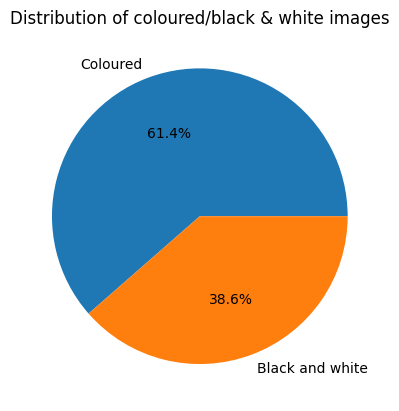

In [12]:
nb_coloured = is_coloured.count(True)
nb_bw = is_coloured.count(False)

plt.pie([nb_coloured, nb_bw], labels=['Coloured', 'Black and white'], autopct='%1.1f%%')
plt.title('Distribution of coloured/black & white images')
plt.show()